In [58]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import keras
from keras import layers

Using TensorFlow backend.


In [4]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('../src'))

# System setup

Model characteristics:
* Continuous inputs, discrete actions
* Discrete events in continuous time

### Flappy Bird

* State: (hight, lower border of the hole, upper border of the hole, time to hole)
* Actions: {fly up, keep falling}
* Reward: time survived

In [5]:
from reinforcement_example.game import Game

In [ ]:
# Play the game
game = Game()
while True:
    print(game.get_state())
    action = int(input())
    game.time_step(action)
    if not game.alive:
        print("DEAD!")
        break

In [6]:
from reinforcement_example.learner import make_model

In [7]:
from reinforcement_example.learner import AbstractLearner

In [8]:
class ScaledModel(object):
    def __init__(self, model, xscale=None, yscale=None):
        self.model = model
        self.xscale = xscale
        self.yscale = yscale
    
    def fit(self, X, Y):
        rX = X / self.xscale[np.newaxis, :] if self.xscale is not None else X
        rY = Y / self.yscale if self.yscale is not None else Y
        self.model.fit(rX, rY)
        
    def predict(self, X):
        rX = X / self.xscale[np.newaxis, :] if self.xscale is not None else X
        res = self.model.predict(rX)
        return res * self.yscale if self.yscale is not None else res

In [9]:
def logodds_to_probs(odds):
    scaled = np.asarray(odds) - np.expand_dims(np.max(odds, axis=-1), axis=-1)
    transformed = np.exp(scaled)
    return transformed / np.expand_dims(np.sum(transformed, axis=-1), axis=-1)

In [10]:
class ValueToPolicy(object):
    def __init__(self, value_model, scale=1.0):
        self.value_model = value_model
        self.num_actions = len(value_model)
        self.scale = scale
        
    def predict(self, states):
        res = np.array([model.predict(states)[:, 0] for model in self.value_model]) / self.scale
        # res has axes: action, batch
        # Result must have axes: batch, action
        return res.T
    
    def set_scale(self, scale):
        self.scale = scale

In [11]:
# class SoftPolicy(object):
#     def __init__(self, base, prob_random):
#         self.base = base
#         self.p = prob_random
        
#     def predict(self, states):
#         res = self.base.predict(states)
#         num_actions = res.shape[1]
#         uniform = np.ones(num_actions) / num_actions
#         res = self.p * uniform + (1 - self.p) * res
#         return res

In [12]:
def random_round(a):
    shape = a.shape if hasattr(a, 'shape') else (1,)
    flr = np.floor(a).astype(np.int64, copy=False)
    return flr + (np.random.rand(*shape) < a - flr)

In [13]:
def weights_to_inds(weights, amplification=10):
    copy_counts = random_round(weights * amplification)
    res = np.empty(np.sum(copy_counts), dtype=np.int64)
    ptr = 0
    for i, cnt in enumerate(copy_counts):
        res[ptr:ptr+cnt] = i
        ptr += cnt
    return res

In [14]:
class MCLearner(AbstractLearner):
    def __init__(self, state_dim, num_actions, reward_scale=1.0):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.reward_scale = reward_scale
        self.value_model = [ScaledModel(make_model(state_dim, 1), yscale=reward_scale) for i in range(num_actions)]
        #self.policy = make_model(state_dim, num_actions)
        self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        self.histories = []
        self.history = []
        # Helper arrays for faster training
        self.states = np.empty((0, self.state_dim))
        self.actions = np.empty(0, dtype=np.int)
        self.cumrewards = np.empty(0)
        self.cumlogprobs = np.empty(0)
        self.ranges = np.empty((0, 2), dtype=np.int)
        self.actinds = [np.empty(0, dtype=np.int) for i in range(self.num_actions)]
    
    def move(self, state):
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0])
        choice = np.searchsorted(np.cumsum(probs), np.random.rand())
        self.last_action_prob = probs[choice]
        return choice
    
    def learn(self, state, action, reward, next_state, value_proxy):
        self.history.append((np.array(state), action, reward, self.last_action_prob))
        
    def learn_last(self, state, action, reward):
        self.history.append((np.array(state), action, reward, self.last_action_prob))
        self.histories.append(self.history)
        self.history = []
        self._update_value_model()
        
    def _update_value_model(self):
        # Update data structures
        last_states, last_actions, last_rewards, last_actionprob = zip(*self.histories[-1][::-1])
        dsize = len(self.states)
        self.ranges = np.concatenate([self.ranges, np.array([[dsize, dsize + len(last_states)]])])
        dsize += len(last_states)
        self.states = np.concatenate([self.states, np.array(last_states)], axis=0)
        self.actions = np.concatenate([self.actions, np.array(last_actions, dtype=np.int)])
        self.cumrewards = np.concatenate([self.cumrewards, np.cumsum(last_rewards)])
        self.cumlogprobs = np.concatenate([self.cumlogprobs, [0], np.cumsum(np.log(last_actionprob))[:-1]])
        self.actinds = [np.arange(len(self.actions))[self.actions == i] for i in range(self.num_actions)]
        # Training
        policy_logprobs = np.log(logodds_to_probs(self.policy.predict(self.states))[np.arange(dsize), self.actions])
        policy_cumlogprobs = np.zeros(dsize)
        for start, end in self.ranges:
            policy_cumlogprobs[start + 1:end] = np.cumsum(policy_logprobs[start:end - 1])
        predicted_value = np.zeros(dsize)
        for action in range(self.num_actions):
            predicted_value[self.actinds[action]] = \
                self.value_model[action].predict(self.states[self.actinds[action], :]).reshape(-1)
        weights = np.exp(policy_cumlogprobs - self.cumlogprobs)
        assert np.all(weights >= 0)
        for action in range(self.num_actions):
            inds = self.actinds[action][weights_to_inds(weights[self.actinds[action]])]
            self.value_model[action].fit(self.states[inds, :], self.cumrewards[inds])
        # Policy scale
        mse = np.dot(weights, (predicted_value - self.cumrewards) ** 2) / np.sum(weights)
        self.policy.set_scale(self.reward_scale / len(self.histories) + np.sqrt(mse))
        return
        
    def _mse(self):
        """Compute mean-squared error of the predicted action value vs the observed"""
        

In [15]:
from reinforcement_example.learner import train_play

In [16]:
game = Game()
learner = MCLearner(4, 2, reward_scale=game.mean_time_to_hole)

In [17]:
train_play(Game(), learner)[1]

Epoch 1/1
330/330 [==============================] - 0s 1ms/step - loss: 1.3364
Epoch 1/1
240/240 [==============================] - 0s 535us/step - loss: 1.1782


57.54087352161999

In [18]:
history = []

Epoch 1/1
202092/202092 [==============================] - 10s 49us/step - loss: 0.0131
Epoch 1/1
205261/205261 [==============================] - 10s 50us/step - loss: 0.0157
Epoch 1/1
180838/180838 [==============================] - 9s 50us/step - loss: 0.0357
Epoch 1/1
187184/187184 [==============================] - 9s 51us/step - loss: 0.0288
Epoch 1/1
203528/203528 [==============================] - 10s 51us/step - loss: 0.0260
Epoch 1/1
210251/210251 [==============================] - 11s 51us/step - loss: 0.0158
Epoch 1/1
162689/162689 [==============================] - 8s 51us/step - loss: 0.0223
Epoch 1/1
169019/169019 [==============================] - 9s 51us/step - loss: 0.0147
Epoch 1/1
127494/127494 [==============================] - 6s 51us/step - loss: 0.0160
Epoch 1/1
156779/156779 [==============================] - 8s 51us/step - loss: 0.0247
Epoch 1/1
180700/180700 [==============================] - 9s 51us/step - loss: 0.0343
Epoch 1/1
183048/183048 [==============

271374/271374 [==============================] - 13s 47us/step - loss: 0.0235
Epoch 1/1
260090/260090 [==============================] - 12s 47us/step - loss: 0.0158
Epoch 1/1
200199/200199 [==============================] - 9s 47us/step - loss: 0.0335
Epoch 1/1
213481/213481 [==============================] - 10s 47us/step - loss: 0.0233
Epoch 1/1
244399/244399 [==============================] - 12s 48us/step - loss: 0.0374
Epoch 1/1
235858/235858 [==============================] - 11s 47us/step - loss: 0.0203
Epoch 1/1
194798/194798 [==============================] - 9s 47us/step - loss: 0.0292
Epoch 1/1
193935/193935 [==============================] - 9s 47us/step - loss: 0.0176
Epoch 1/1
238032/238032 [==============================] - 11s 48us/step - loss: 0.0352
Epoch 1/1
229460/229460 [==============================] - 11s 47us/step - loss: 0.0173
Epoch 1/1
198580/198580 [==============================] - 10s 48us/step - loss: 0.0198
Epoch 1/1
190977/190977 [====================

211886/211886 [==============================] - 10s 46us/step - loss: 0.0264
Epoch 1/1
218719/218719 [==============================] - 10s 47us/step - loss: 0.0165
Epoch 1/1
228361/228361 [==============================] - 11s 46us/step - loss: 0.0225
Epoch 1/1
230826/230826 [==============================] - 11s 47us/step - loss: 0.0118
Epoch 1/1
159806/159806 [==============================] - 8s 47us/step - loss: 0.0130
Epoch 1/1
193006/193006 [==============================] - 9s 47us/step - loss: 0.0159
Epoch 1/1
232067/232067 [==============================] - 11s 47us/step - loss: 0.0173
Epoch 1/1
234073/234073 [==============================] - 11s 48us/step - loss: 0.0166
Epoch 1/1
201878/201878 [==============================] - 10s 48us/step - loss: 0.0258
Epoch 1/1
215617/215617 [==============================] - 10s 47us/step - loss: 0.0334
Epoch 1/1
232403/232403 [==============================] - 11s 47us/step - loss: 0.0290
Epoch 1/1
231002/231002 [===================

192655/192655 [==============================] - 9s 47us/step - loss: 0.0184
Epoch 1/1
198477/198477 [==============================] - 9s 48us/step - loss: 0.0205
Epoch 1/1
260613/260613 [==============================] - 12s 46us/step - loss: 0.0183
Epoch 1/1
258864/258864 [==============================] - 12s 46us/step - loss: 0.0176
Epoch 1/1
232886/232886 [==============================] - 11s 47us/step - loss: 0.0139
Epoch 1/1
242361/242361 [==============================] - 11s 47us/step - loss: 0.0108
Epoch 1/1
170675/170675 [==============================] - 8s 47us/step - loss: 0.0157
Epoch 1/1
190976/190976 [==============================] - 9s 48us/step - loss: 0.0276
Epoch 1/1
199556/199556 [==============================] - 9s 47us/step - loss: 0.0258
Epoch 1/1
209624/209624 [==============================] - 10s 47us/step - loss: 0.0325
Epoch 1/1
178750/178750 [==============================] - 9s 48us/step - loss: 0.0169
Epoch 1/1
198728/198728 [=======================

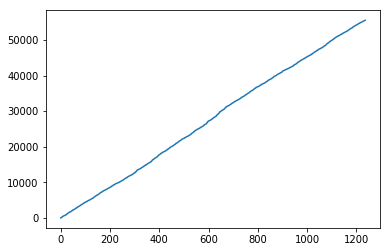

In [38]:
for i in range(10000):
    history.append(train_play(Game(), learner)[1])
    if os.path.exists("002_reinforcement_example_v3_stop"):
        break
plt.plot(np.cumsum(history))

Epoch 1/1
 2592/12280 [=====>........................] - ETA: 0s - loss: 0.0026

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


12280/12280 [==============================] - 1s 60us/step - loss: 0.0016
Epoch 1/1
7533/7533 [==============================] - 0s 54us/step - loss: 0.0064
Epoch 1/1
30234/30234 [==============================] - 2s 58us/step - loss: 4.0684e-04
Epoch 1/1
20382/20382 [==============================] - 1s 56us/step - loss: 0.0189
Epoch 1/1
33771/33771 [==============================] - 2s 55us/step - loss: 6.4931e-04
Epoch 1/1
17369/17369 [==============================] - 1s 56us/step - loss: 0.0144
Epoch 1/1
38387/38387 [==============================] - 2s 57us/step - loss: 3.0927e-04
Epoch 1/1
14451/14451 [==============================] - 1s 57us/step - loss: 0.0039
Epoch 1/1
53986/53986 [==============================] - 3s 57us/step - loss: 1.7448e-04
Epoch 1/1
18445/18445 [==============================] - 1s 68us/step - loss: 0.0036
Epoch 1/1
37655/37655 [==============================] - 2s 58us/step - loss: 3.9592e-04
Epoch 1/1
16621/16621 [==============================] - 

36438/36438 [==============================] - 2s 57us/step - loss: 5.5910e-04
Epoch 1/1
22942/22942 [==============================] - 1s 55us/step - loss: 0.0072
Epoch 1/1
76330/76330 [==============================] - 4s 53us/step - loss: 2.6426e-04
Epoch 1/1
32090/32090 [==============================] - 2s 54us/step - loss: 0.0055
Epoch 1/1
32971/32971 [==============================] - 2s 56us/step - loss: 5.9205e-04
Epoch 1/1
25026/25026 [==============================] - 1s 53us/step - loss: 0.0067
Epoch 1/1
16381/16381 [==============================] - 1s 53us/step - loss: 4.7175e-04
Epoch 1/1
11956/11956 [==============================] - 1s 58us/step - loss: 0.0053
Epoch 1/1
61480/61480 [==============================] - 3s 53us/step - loss: 3.3372e-04
Epoch 1/1
21506/21506 [==============================] - 1s 53us/step - loss: 0.0011
Epoch 1/1
31693/31693 [==============================] - 2s 54us/step - loss: 3.7502e-04
Epoch 1/1
32916/32916 [============================

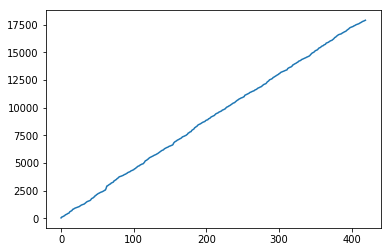

In [103]:
for i in range(100):
    history.append(train_play(Game(), learner)[1])
plt.plot(np.cumsum(history))

In [67]:
    def learner_update_value_model(self):
        # Update data structures
        last_states, last_actions, last_rewards, last_actionprob = zip(*self.histories[-1][::-1])
        dsize = len(self.states)
        self.ranges = np.concatenate([self.ranges, np.array([[dsize, dsize + len(last_states)]])])
        dsize += len(last_states)
        self.states = np.concatenate([self.states, np.array(last_states)], axis=0)
        self.actions = np.concatenate([self.actions, np.array(last_actions, dtype=np.int)])
        self.cumrewards = np.concatenate([self.cumrewards, np.cumsum(last_rewards)])
        self.cumlogprobs = np.concatenate([self.cumlogprobs, [0], np.cumsum(np.log(last_actionprob))[:-1]])
        self.actinds = [np.arange(len(self.actions))[self.actions == i] for i in range(self.num_actions)]
        # Training
        policy_logprobs = np.log(logodds_to_probs(self.policy.predict(self.states))[np.arange(dsize), self.actions])
        policy_cumlogprobs = np.zeros(dsize)
        for start, end in self.ranges:
            policy_cumlogprobs[start + 1:end] = np.cumsum(policy_logprobs[start:end - 1])
        predicted_value = np.zeros(dsize)
        for action in range(self.num_actions):
            predicted_value[self.actinds[action]] = \
                self.value_model[action].predict(self.states[self.actinds[action], :]).reshape(-1)
        weights = np.exp(policy_cumlogprobs - self.cumlogprobs)
        assert np.all(weights >= 0)
        for action in range(self.num_actions):
            for epoch in range(20):
                inds = self.actinds[action][weights_to_inds(weights[self.actinds[action]])]
                self.value_model[action].fit(self.states[inds, :], self.cumrewards[inds])
        # Policy scale
        mse = np.dot(weights, (predicted_value - self.cumrewards) ** 2) / np.sum(weights)
        self.policy.set_scale(self.reward_scale / len(self.histories) + np.sqrt(mse))
        return

    learner_update_value_model(learner)

Epoch 1/1
252449/252449 [==============================] - 15s 58us/step - loss: 0.0241
Epoch 1/1
252516/252516 [==============================] - 15s 58us/step - loss: 0.0240
Epoch 1/1
252500/252500 [==============================] - 15s 60us/step - loss: 0.0239
Epoch 1/1
252541/252541 [==============================] - 16s 62us/step - loss: 0.0239
Epoch 1/1
252466/252466 [==============================] - 16s 63us/step - loss: 0.0239
Epoch 1/1
252606/252606 [==============================] - 15s 59us/step - loss: 0.0240
Epoch 1/1
252566/252566 [==============================] - 15s 59us/step - loss: 0.0239
Epoch 1/1
252422/252422 [==============================] - 15s 58us/step - loss: 0.0239
Epoch 1/1
252595/252595 [==============================] - 15s 60us/step - loss: 0.0241
Epoch 1/1
252507/252507 [==============================] - 15s 60us/step - loss: 0.0240
Epoch 1/1
252503/252503 [==============================] - 15s 60us/step - loss: 0.0240
Epoch 1/1
252497/252497 [=======

In [39]:
np.mean(history)

44.888622724431194

In [40]:
len(history)

1237

In [107]:
import pickle
with open('002_reinforcement_example_v2_learner.pickle', 'wb') as f:
    pickle.dump({
        'histories': learner.histories,
        'value_model': [
            {
                'config': model.get_config(),
                'weights': model.get_weights()
            }
            for model in learner.value_model
        ]
    }, f)

AttributeError: 'ScaledModel' object has no attribute 'get_config'

In [74]:
import pickle
with open('002_reinforcement_example_v3_learner.pickle', 'wb') as f:
    pickle.dump(dict([(foo, learner.__dict__[foo]) for foo in learner.__dict__
                      if foo != "value_model" and foo != 'policy'] +
                     [("value_model", [{
                         "xscale": model.xscale,
                         "yscale": model.yscale,
                         "config": model.model.get_config(),
                         "weights": model.model.get_weights()
                     } for model in learner.value_model])]), f)

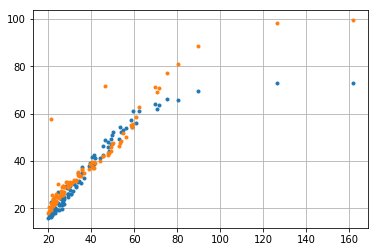

In [69]:
foo = np.zeros((100, 4))
for i in range(foo.shape[0]):
    foo[i, :4] = Game().get_state()
fooy0 = learner.value_model[0].predict(foo).reshape(-1)
fooy1 = learner.value_model[1].predict(foo).reshape(-1)
plt.plot(foo[:, 3], fooy0, '.')
plt.plot(foo[:, 3], fooy1, '.')
plt.grid()

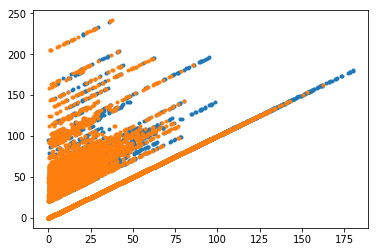

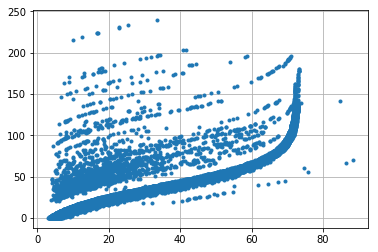

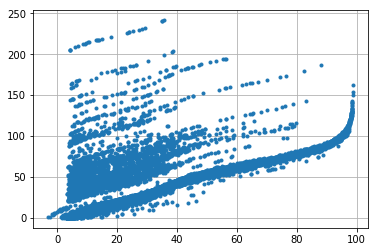

In [70]:
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = learner.cumrewards[learner.actinds[action]]
            plt.plot(X[:, 3], Y, '.')
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = learner.cumrewards[learner.actinds[action]]
            plt.figure()
            plt.plot(learner.value_model[action].predict(X), Y, '.')
            #plt.title('Prediction vs response, RMS = {}'.format(learner.value_model[action].evaluate(X[inds], Y[inds])))
            plt.grid(True)

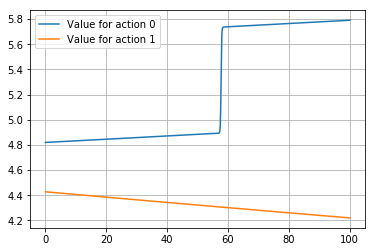

In [71]:
foo_heights = np.linspace(0, 100, 1000)
foo_states = np.empty((len(foo_heights), 4))
foo_states[:, 0] = foo_heights
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = 1
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_heights, foo_v, label="Value for action {}".format(action))
plt.grid(True)
plt.legend()

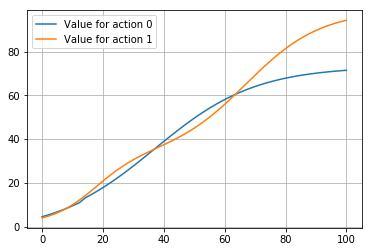

In [72]:
foo_dists = np.linspace(0, 100)
foo_states = np.empty((len(foo_dists), 4))
foo_states[:, 0] = 50
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = foo_dists
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_dists, foo_v, label="Value for action {}".format(action))
plt.legend()
plt.grid(True)

In [73]:
learner.policy.scale

7.115488386770077

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


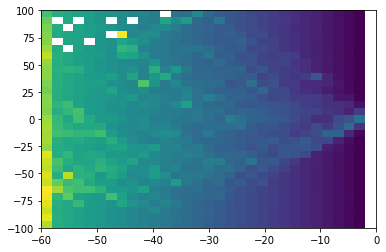

In [63]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += learner.cumrewards[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


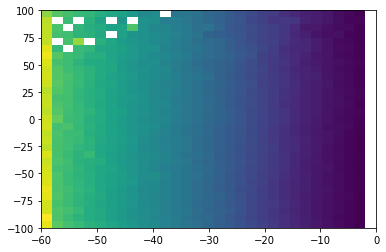

In [68]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
predictions = np.mean([model.predict(learner.states).reshape(-1) for model in learner.value_model], axis=0)
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += predictions[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

In [50]:
foo = np.zeros(2)
foo[[0,0,1,1,0]] += 1
foo

array([1., 1.])

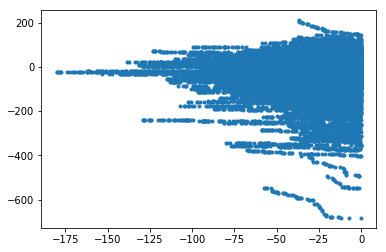

In [49]:
plt.plot(-learner.states[:, 3], np.sort(dy), '.')

#### Test the ability of the neural network to learn...

In [ ]:
model = make_model(6, 1)

In [ ]:
data = np.random.rand(6000).reshape((1000, 6)) * 3

In [ ]:
for row in data:
    model.train_on_batch(row[np.newaxis, :], row[[-1]])

In [ ]:
foo = np.random.rand(600).reshape((100, 6)) * 3
fooy = model.predict(foo)
plt.plot(foo[:, -1], fooy.reshape(-1), '.')
plt.grid(True)